In [1]:
import os
import argparse
import json

import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

from monai.utils import set_determinism
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import first
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceFocalLoss, FocalLoss
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.transforms import AsDiscrete


In [2]:
import sys
libdir = "../"
sys.path.insert(0, libdir)
from utils.data import get_surf_srep_split, get_srep_data_transform
import utils.misc as workspace

In [3]:
exp_name = "debug3d_1"
experiment_dir = os.path.join(libdir, "experiments", exp_name)

# Setup the checkpoint and model eval dirs in exp_dir
checkpt_dir = os.path.join(experiment_dir, workspace.checkpoint_subdir)
eval_dir = os.path.join(experiment_dir, workspace.evaluation_subdir)
if not os.path.isdir(checkpt_dir):
    os.makedirs(checkpt_dir)
if not os.path.isdir(eval_dir):
    os.makedirs(eval_dir)

with open(os.path.join(experiment_dir, "specs.json"), "r") as f:
    specs = json.load(f)
train_data_dir = specs["DataSource"]
learning_rate = specs["LearningRate"]
num_epochs = specs["Epochs"]
save_epoch = specs["SaveEvery"]
batch_size = specs["BatchSize"]
if_debug = specs["Debug"]
resize_shape = specs["ResizeShape"]
print(
    f'Learning Rate:{learning_rate} | Epochs:{num_epochs} | BatchSize:{batch_size}')
print(f"Training data dir: {train_data_dir}")


Learning Rate:0.001 | Epochs:1000 | BatchSize:3
Training data dir: /home/local/KHQ/ninad.khargonkar/Desktop/srep-dl/unet-skel-2d/data/train_3d


In [10]:
data_transforms = get_srep_data_transform((resize_shape, resize_shape, resize_shape))
trn_files, val_files, tst_files = get_surf_srep_split(train_data_dir, random_shuffle=False, debug=if_debug)

all_files = trn_files + val_files
val_ds = CacheDataset(data=val_files + tst_files, transform=data_transforms, cache_rate=0.1, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)

device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

criterion1 = DiceLoss(sigmoid=True)
criterion2 = FocalLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [11]:
model.eval()
workspace.load_model_checkpoint(experiment_dir, "latest", model)

452

In [20]:
def visualize_model(model, val_loader, device=torch.device("cuda:0"), slice=80):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (128, 128, 128)
            sw_batch_size = 4
            # val_outputs = sliding_window_inference(
            #     val_data["image"].to(device), roi_size, sw_batch_size, model
            # )
            # plot the slice [:, :, 10]
            val_inp = val_data["image"].to(device)
            val_lab = val_data["label"].to(device)
            out_logits = model(val_inp)
            out_img = torch.sigmoid(out_logits).detach().cpu()
            print(val_inp.shape, val_lab.shape, out_img.shape)            
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, slice], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, slice])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice])
            plt.imshow(img_as_ubyte(out_img[0, 0, :, :, slice]))
            plt.show()

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


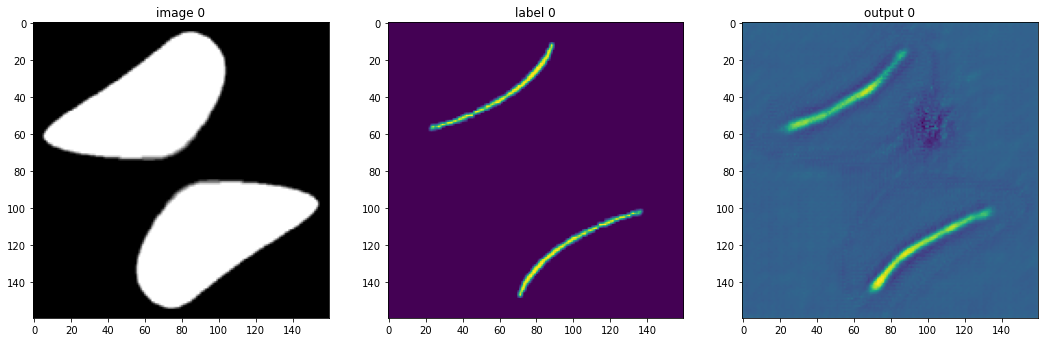

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


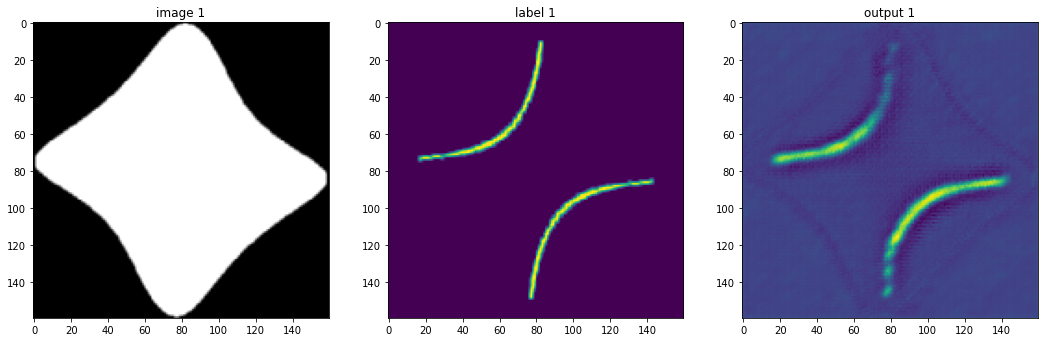

In [17]:
visualize_model(model, val_loader, device)

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


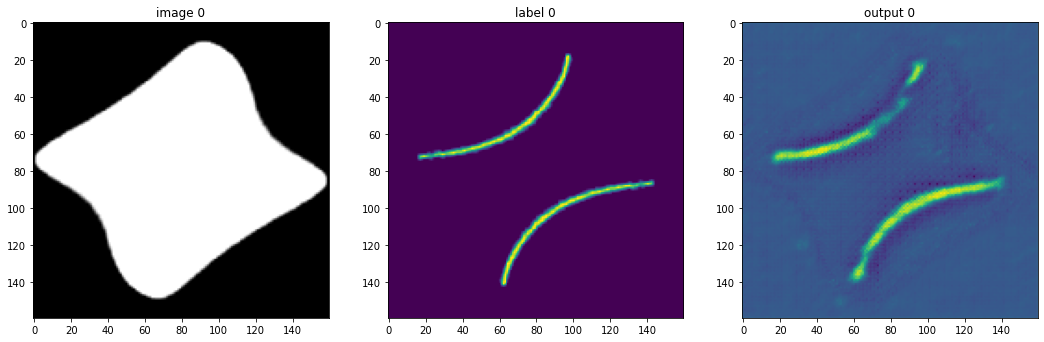

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


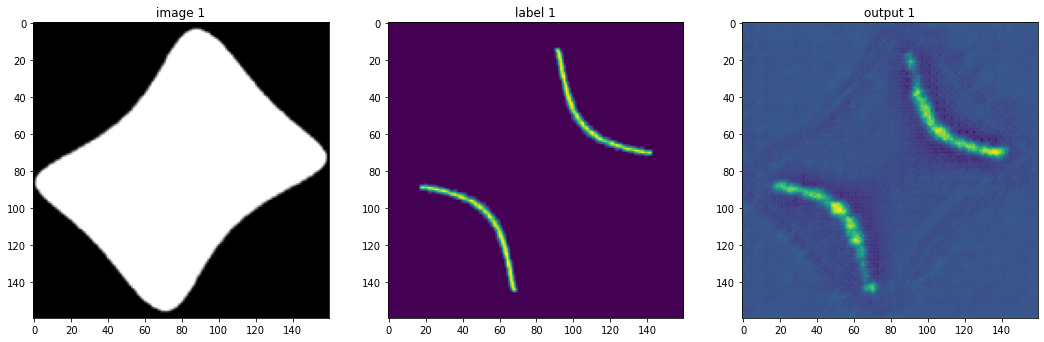

In [18]:
visualize_model(model, val_loader, device, slice=55)

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


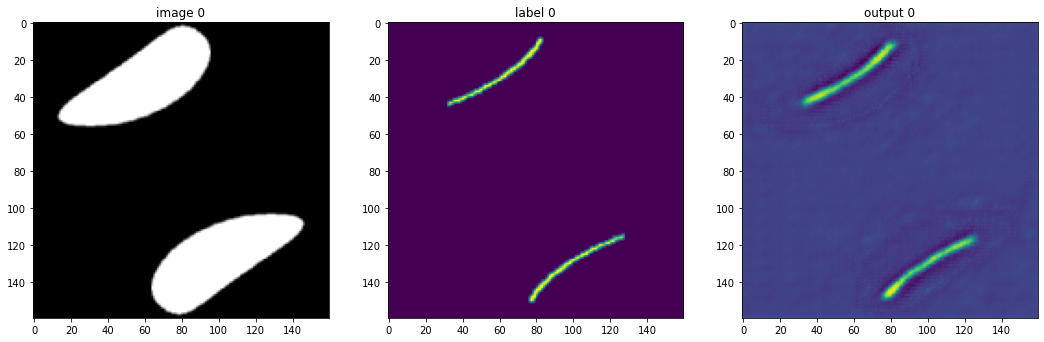

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


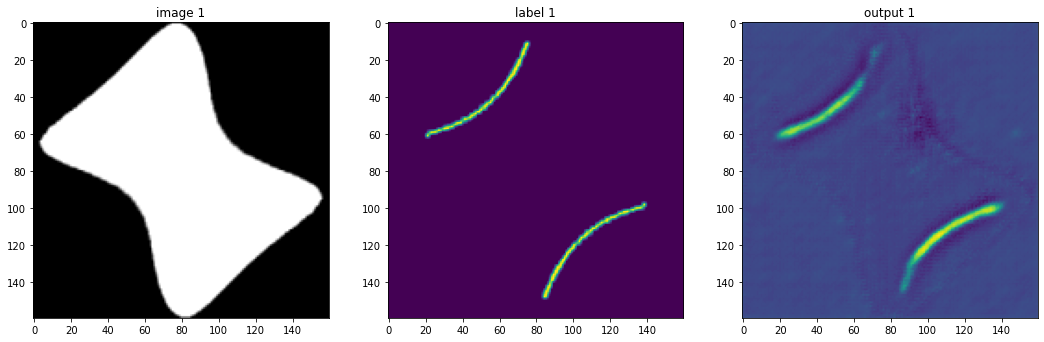

In [19]:
visualize_model(model, val_loader, device, slice=102)

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


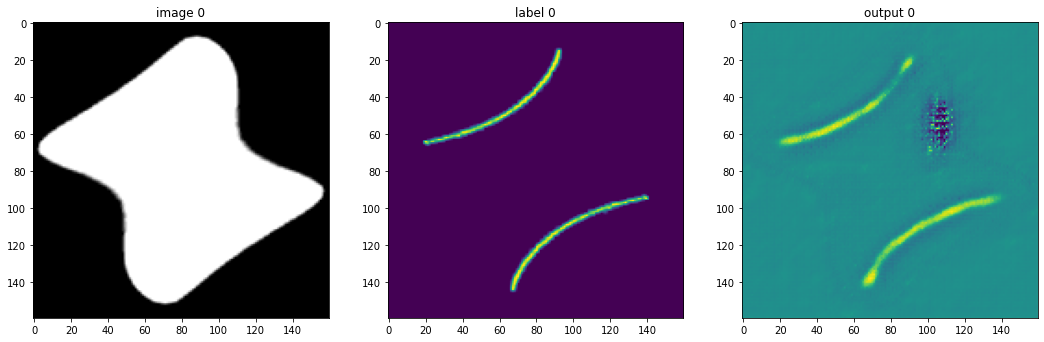

torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])


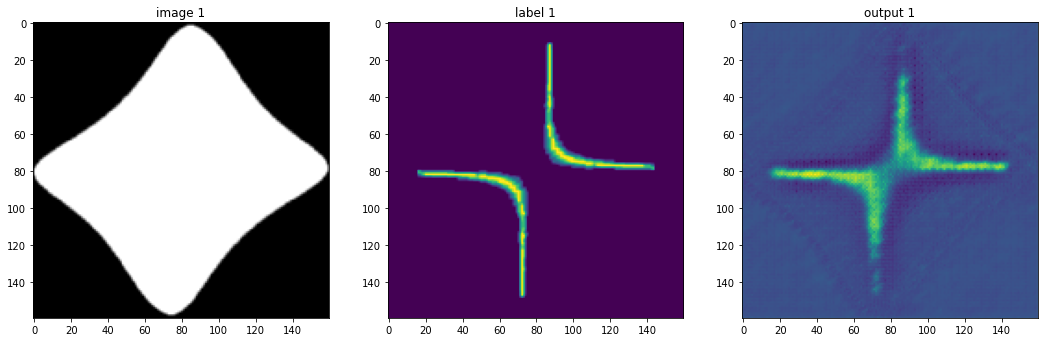

In [22]:
visualize_model(model, val_loader, device, slice=67)